# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы Smart и Ultra. 
Необходимо построить модель для задачи классификации, которая выберет подходящий тариф.

В качестве критерия качества выберем метрику Accuracy. Пороговая правильность 0.75. 

# Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 
Известно:

    сalls — количество звонков,
    minutes — суммарная длительность звонков в минутах,
    messages — количество sms-сообщений,
    mb_used — израсходованный интернет-трафик в Мб,
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier


## Загрузка и осмотр файл

In [2]:
df = pd.read_csv('./users_behavior.csv')

In [3]:
#посмотрим таблицу
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков нет, типы данных менять не требуется.

In [5]:
df.duplicated().sum()

0

Дубликатов нет.

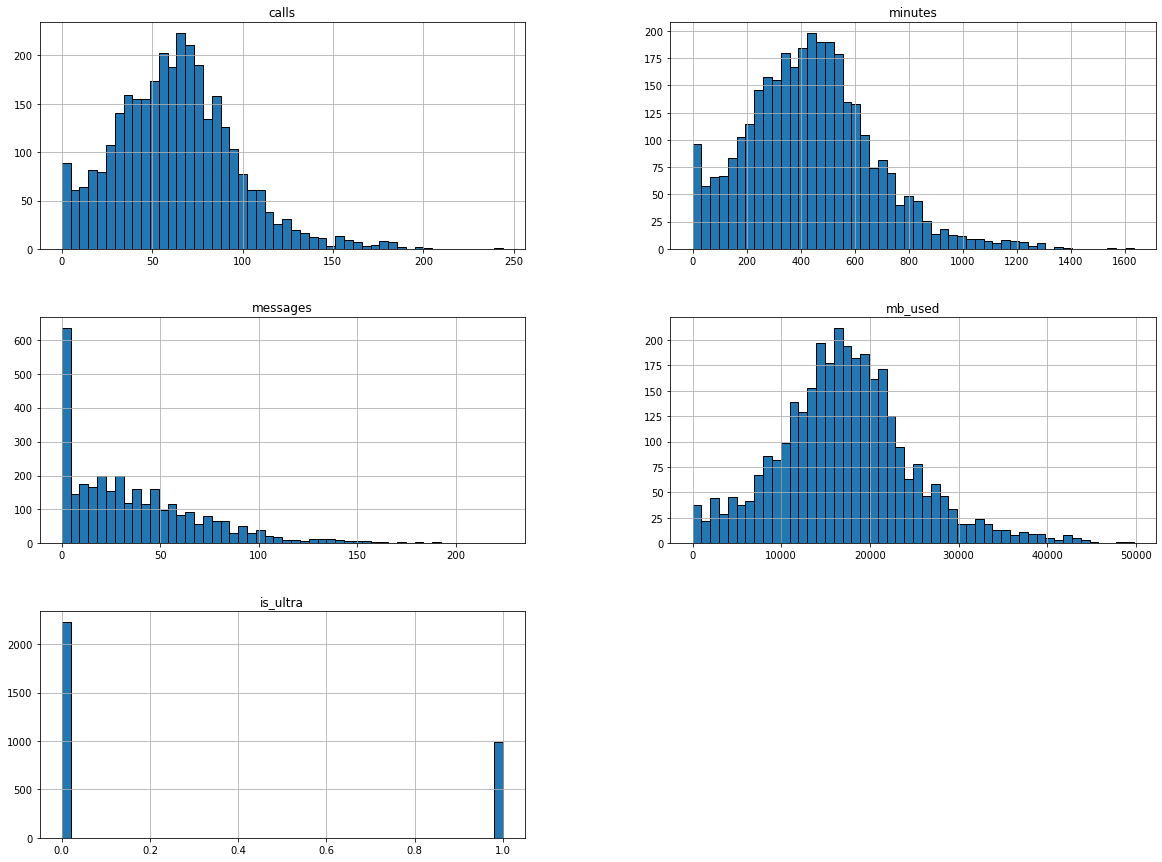

In [6]:
df.hist(bins=50, figsize=(20,15), edgecolor='black')
plt.show()

В данных нет каких-либо выбросов и аномалий. Тип данных соответствует, пропусков и дубликатов нет.

## Разобьем данные на выборки

Разделим на обучающую, валидационную и тестовую выборки:

In [7]:
train, test = train_test_split(df, test_size=0.2, random_state=12345)

In [8]:
final_train, valid = train_test_split(train, test_size=0.2, random_state=12345)

In [9]:
#в features_valid сохранили признаки, а в target_valid - целевой признак
features_valid = valid.drop(['is_ultra'], axis=1)
target_valid = valid['is_ultra']

In [10]:
features_train = final_train.drop(['is_ultra'], axis=1)
target_train = final_train['is_ultra']

In [11]:
#проверка на правильность разделения
len(df) - (len(test) + len(final_train) + len(valid))

0

## Исследуем модели

### Дерево решений

In [12]:
best_depth = 0
best_accuracy = 0
for depth in range(1, 10):
    #обучили модель с заданной глубиной дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model.fit(features_train,target_train)
    accuracy = model.score(features_valid,target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth
        
print('Глубина дерева:', best_depth, '  Качество модели TreeClassifier:', best_accuracy)

Глубина дерева: 7   Качество модели TreeClassifier: 0.7650485436893204


### Логистическая регрессия

In [13]:
#выбрали параметр solver='liblinear', так как у нас небольшая выборка данных
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train,target_train)
accuracy = model.score(features_valid,target_valid)

print('Качество модели LogisticRegression:', accuracy)

Качество модели LogisticRegression: 0.7203883495145631


### Случайный лес

In [14]:
best_depth = 0
best_est = 0
best_accuracy = 0
for depth in range(1,15):
    for est in range(10,50,10):
        model = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=est)
        model.fit(features_train,target_train)
        accuracy = model.score(features_valid,target_valid)
        if accuracy > best_accuracy:
            best_depth = depth
            best_est = est
            best_accuracy = accuracy
        
print('Глубина дерева:', best_depth, '  Количество деревьев:', best_est, ' \
      Качество модели ForestClassifier:', best_accuracy)
    

Глубина дерева: 13   Количество деревьев: 40        Качество модели ForestClassifier: 0.7941747572815534


### Вывод:     
  По валидационной выборке самая качественная модель "Случайный лес" = 0.7941 с гиперпараметрами max_depth = 13, n_estimators = 40

## Проверим модель на тестовой выборке

In [15]:
#сохранили признаки тестовой выборки
features_test = test.drop('is_ultra', axis=1)
target_test = test['is_ultra']

### Дерево решений

In [16]:
# обучили модель с заданной глубиной дерева
model = DecisionTreeClassifier(random_state=12345, max_depth = 5)
model.fit(features_train,target_train)
best_accuracy = model.score(features_test,target_test)
        
print('Глубина дерева:', 5, '  Качество модели TreeClassifier:', best_accuracy)

Глубина дерева: 5   Качество модели TreeClassifier: 0.7791601866251944


### Логистическая регрессия

In [17]:
#выбрали параметр solver='liblinear', так как у нас небольшая выборка данных
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train,target_train)
accuracy_logreg = model.score(features_test,target_test)

print('Качество модели LogisticRegression:', accuracy_logreg)

Качество модели LogisticRegression: 0.749611197511664


### Случайный лес

In [18]:
model = RandomForestClassifier(random_state=12345, max_depth = 8, n_estimators = 30)
model.fit(features_train,target_train)
best_accuracy_forest = model.score(features_test,target_test)
        
print('Глубина дерева:', 8, '  Количество деревьев:', 30, '  \
    Качество модели ForestClassifier:', best_accuracy_forest)

Глубина дерева: 8   Количество деревьев: 30       Качество модели ForestClassifier: 0.807153965785381


### Вывод:

   Самое лучшее качество у модели "Случайный лес" = 0.8071 с гипермараметрами max_depth = 8, n_estimators = 30

## Проверим модели на адекватность

In [23]:
#Проверим модель с помощью классификатора-DummyClassifier,
#с использованием стратегии - most_frequent всегда предсказывает наиболее частую метку в обучающем наборе
dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy.fit(features_train,target_train)
accuracy_dummy = dummy.score(features_test,target_test)
print('Классификатор "Dummy" :', accuracy_dummy)
print('Качество модели "Дерево решений": ', best_accuracy)
print('Качество модели "Логистическая регрессия": ', accuracy_logreg)
print('Качество модели "Случайный лес": ', best_accuracy_forest)


Классификатор "Dummy" : 0.6951788491446346
Качество модели "Дерево решений":  0.7791601866251944
Качество модели "Логистическая регрессия":  0.749611197511664
Качество модели "Случайный лес":  0.807153965785381


## Вывод:
    
   Мы проверили три модели: "Дерево решений", "Логистическая регрессия" и "Случайный лес". 
   
   Самая качественная модель "Случайный лес" = 0.8071 с гиперпараметрами max_depth = 8, n_estimators = 30